## 2. Mean-Variance Optimization
### Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

### Data

In [2]:
info = pd.read_excel("../data/multi_asset_etf_data.xlsx", sheet_name="descriptions")
total_ret = pd.read_excel("../data/multi_asset_etf_data.xlsx", sheet_name="total returns")
total_ret = total_ret.set_index('Date')
excess_ret = pd.read_excel("../data/multi_asset_etf_data.xlsx", sheet_name="excess returns")
excess_ret = excess_ret.set_index('Date')

info

,ticker,shortName,quoteType,currency,volume,totalAssets,longBusinessSummary
0,SPY,SPDR S&P 500,ETF,USD,101107853,358229114880,The Trust seeks to achieve its investment obje...
1,EFA,iShares MSCI EAFE ETF,ETF,USD,33352872,43798241280,The fund generally will invest at least 80% of...
2,EEM,iShares MSCI Emerging Index Fun,ETF,USD,47539498,25870192640,The fund generally will invest at least 80% of...
3,PSP,Invesco Global Listed Private E,ETF,USD,120371,171932880,The fund generally will invest at least 90% of...
4,QAI,IQ Hedge MultiIQ Hedge Multi-St,ETF,USD,138713,707315584,"The fund is a ""fund of funds"" which means it i..."
5,HYG,iShares iBoxx $ High Yield Corp,ETF,USD,48935762,12276870144,The underlying index is a rules-based index co...
6,DBC,Invesco DB Commodity Index Trac,ETF,USD,2314311,3708376064,The fund pursues its investment objective by i...
7,IYR,iShares U.S. Real Estate ETF,ETF,USD,12097258,4077254400,The fund seeks to track the investment results...
8,IEF,iShares 7-10 Year Treasury Bond,ETF,USD,7992450,23017226240,The underlying index measures the performance ...
9,BWX,SPDR Bloomberg International Tr,ETF,USD,369873,809217792,"The fund generally invests substantially all, ..."


In [3]:
total_ret.head()
# SHV is the risk-free rate

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SHV,SPY,TIP
Date,,,,,,,,,,,,
2009-04-30,0.008993,-0.001000,0.155582,0.115190,0.138460,-0.027452,0.296151,0.230202,0.022882,0.000554,0.099346,-0.017952
2009-05-31,0.053672,0.162663,0.159400,0.131918,0.028555,-0.020773,0.022727,0.053892,0.027865,-0.000472,0.058454,0.019967
2009-06-30,0.005149,-0.026259,-0.022495,-0.014050,0.033516,-0.005572,-0.024863,0.045449,-0.003436,0.000599,-0.000655,0.001982
2009-07-31,0.031284,0.018568,0.110146,0.100415,0.069191,0.008317,0.105799,0.143247,0.015326,-0.000027,0.074606,0.000879
2009-08-31,0.007628,-0.040365,-0.013136,0.045031,-0.016969,0.007635,0.131939,0.033413,-0.004151,0.000436,0.036939,0.008413


In [4]:
total_ret_u = total_ret.drop(columns=["SHV"])

In [5]:
excess_ret.head()

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2009-04-30,0.008439,-0.001554,0.155028,0.114636,0.137906,-0.028006,0.295597,0.229649,0.022329,0.098792,-0.018505
2009-05-31,0.054144,0.163134,0.159872,0.132390,0.029027,-0.020301,0.023199,0.054364,0.028337,0.058925,0.020438
2009-06-30,0.004549,-0.026858,-0.023094,-0.014649,0.032917,-0.006171,-0.025462,0.044850,-0.004035,-0.001254,0.001383
2009-07-31,0.031312,0.018595,0.110173,0.100442,0.069218,0.008344,0.105826,0.143274,0.015353,0.074633,0.000906
2009-08-31,0.007193,-0.040800,-0.013571,0.044595,-0.017404,0.007200,0.131503,0.032977,-0.004586,0.036504,0.007977


### Functions

In [45]:
# summary assets' mean return, voaltility(stdev) and sharpe ratio
from math import tan


def summary_stat(df, annual_factor):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["Sharpe Ratio"] = result["mean"]/result["volatility"]
    return result

def display_portfolio(weight, df, name, annual_factor):
    '''given weight and assets and portfolio name, 
    display portfolio's performance'''
    portfolio = (weight * df).sum(axis=1)
    portfolio_sum = summary_stat(portfolio.to_frame(name), annual_factor)
    return portfolio_sum

# calculate tangency portfolio omega
def cal_tangency_w(df, annual_factor):
    '''give assets return and annualize factor, return tangency weight'''
    N = df.shape[1]

    Sigma = df.cov() * annual_factor  # covariance matrix, annualized
    mean =  df.mean() * annual_factor 
    Sigma_inv = np.linalg.inv(Sigma)
    omega_t = (1/(np.ones(N) @ Sigma_inv @ mean)) * Sigma_inv @ mean
    return pd.Series(omega_t, index=df.columns)

# 
def cal_GMV_w(df, annual_factor):
    '''give assets return and annulize factor return global minimum variance weight'''
    N = df.shape[1]

    Sigma = df.cov() * annual_factor  # covariance matrix, annualized
    Sigma_inv = np.linalg.inv(Sigma)
    omega_v = (1/(np.ones(N) @ Sigma_inv @ np.ones(N))) * Sigma_inv @ np.ones(N)
    return pd.Series(omega_v, index=df.columns)

# 
def cal_delta(mu_p, df, annual_factor=12):
    '''give target mu_p, assets return and annualize factor, return delta and weight'''
    mu_p_ann = mu_p * annual_factor
    mu = df.mean() * annual_factor
    tangency_w = cal_tangency_w(df, annual_factor)
    GMV_w = cal_GMV_w(df, annual_factor)
    delta = (mu_p_ann - mu.T @ GMV_w)/(mu.T @ tangency_w - mu.T @ GMV_w)
    weight_star = delta * tangency_w + (1-delta) * GMV_w
    return delta, weight_star


def cal_risk_parity_w(df):
    std = df.std()
    risk_parity_w = 1/std/(1/std).sum()
    return risk_parity_w


### Constant values

In [7]:
annual_factor = 12
round_num = 2
N = total_ret_u.shape[1]

### 1. Summary Statistics
#### (a) Calculate and display the mean and volatility of each asset’s total return. (Recall we use volatility to refer to standard deviation.)

In [8]:
summary_df = summary_stat(total_ret_u, annual_factor)
summary_df

,mean,volatility,Sharpe Ratio
BWX,0.004653,0.078535,0.059248
DBC,0.038846,0.180186,0.215590
EEM,0.072621,0.191787,0.378655
EFA,0.081124,0.161885,0.501125
HYG,0.071588,0.089403,0.800730
IEF,0.025833,0.060077,0.429996
IYR,0.150128,0.184407,0.814113
PSP,0.133272,0.221299,0.602227
QAI,0.022862,0.048879,0.467723
SPY,0.150293,0.144811,1.037857


#### (b) Which assets have the best and worst Sharpe ratios
* SPY has the best Sharpe ratio 1.04
* BWX has the worst Sharpe ratio 0.06

In [9]:
summary_df.nlargest(1, "Sharpe Ratio")

,mean,volatility,Sharpe Ratio
SPY,0.150293,0.144811,1.037857


In [10]:
summary_df.nsmallest(1, "Sharpe Ratio")

,mean,volatility,Sharpe Ratio
BWX,0.004653,0.078535,0.059248


### 2. Descriptive Analysis
#### (a) Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
* The correlation matrix is shown below. 
* (EFA, PSP) has the highest corr, and (DBC, IEF) has the lowest corr.

In [11]:
corr_matrix = total_ret_u.corr()
corr_matrix.round(round_num)

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
BWX,1.00,0.33,0.60,0.58,0.54,0.35,0.41,0.51,0.64,0.43,0.58
DBC,0.33,1.00,0.56,0.58,0.45,-0.41,0.28,0.48,0.53,0.49,0.07
EEM,0.60,0.56,1.00,0.85,0.72,-0.24,0.60,0.79,0.79,0.73,0.23
EFA,0.58,0.58,0.85,1.00,0.76,-0.26,0.68,0.91,0.84,0.87,0.20
HYG,0.54,0.45,0.72,0.76,1.00,-0.09,0.75,0.82,0.76,0.76,0.31
IEF,0.35,-0.41,-0.24,-0.26,-0.09,1.00,-0.02,-0.25,-0.04,-0.27,0.68
IYR,0.41,0.28,0.60,0.68,0.75,-0.02,1.00,0.75,0.62,0.74,0.33
PSP,0.51,0.48,0.79,0.91,0.82,-0.25,0.75,1.00,0.82,0.90,0.23
QAI,0.64,0.53,0.79,0.84,0.76,-0.04,0.62,0.82,1.00,0.83,0.40
SPY,0.43,0.49,0.73,0.87,0.76,-0.27,0.74,0.90,0.83,1.00,0.20


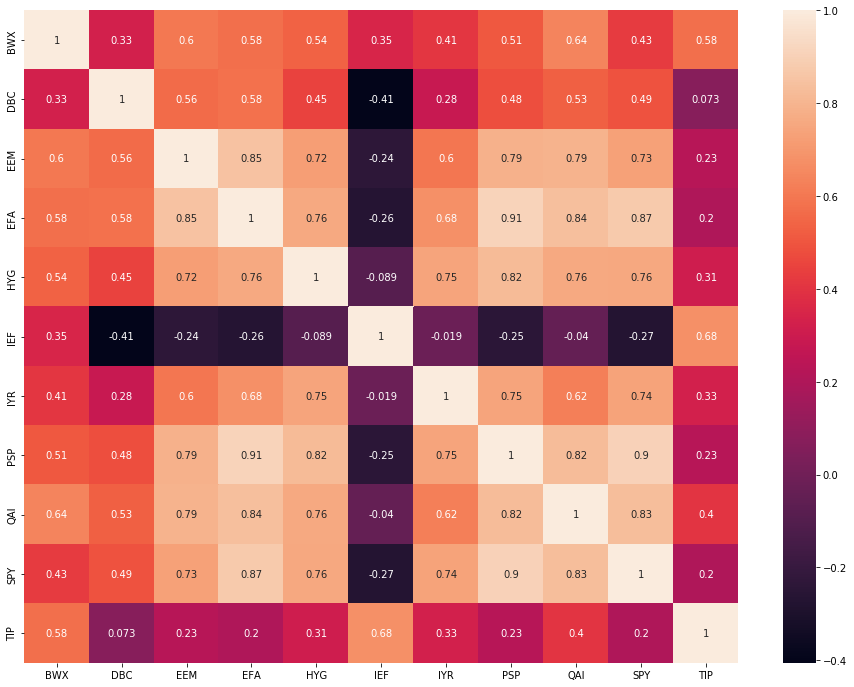

In [49]:
# plt.figure(figsize=(10, 8))
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True)

In [13]:
corr = corr_matrix.values
corr_ma = corr.copy()
for i in range(len(corr)):
    corr_ma[i, i] = -1

In [14]:
max_ind = np.unravel_index(corr_ma.argmax(), corr_ma.shape)
max_name = [corr_matrix.columns[max_ind[0]], corr_matrix.columns[max_ind[1]]]
min_ind = np.unravel_index(corr.argmin(), corr.shape)
min_name = [corr_matrix.columns[min_ind[0]], corr_matrix.columns[min_ind[1]]]

print("Max pair: (%s, %s) \nMin pair: (%s, %s)" %
      (max_name[0], max_name[1], min_name[0], min_name[1]))


Max pair: (EFA, PSP) 
Min pair: (DBC, IEF)


#### (b) How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?
* **TIPS** have the highest Sharpe ratios than IEF and BWX--they have a low mean, but a very low volatility. Furthermore, they have **outperformed Domestic bonds** in terms of mean and in terms of volatility.
* **IEF** are the iShares 7-10 Year Treasury Bond, which represent domestic bonds, and **BWX** are the SPDR Bloomberg International Treasury bonds representing foreign bonds. 
* Notably, TIPS have very low correlation to the other assets

In [15]:
summary_df.loc[['TIP', 'IEF', 'BWX']]

,mean,volatility,Sharpe Ratio
TIP,0.034967,0.047833,0.731032
IEF,0.025833,0.060077,0.429996
BWX,0.004653,0.078535,0.059248


#### (c) Based on the data, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?
* Noticing in the heatmap, TIPS has a very low correlation to other assets, TIPS provide a great deal of diversification to all assets except IEF, to which they still provide some diversification. 

### 3. The MV frontier.
#### (a) Compute and display the weights of the tangency portfolios: $w^t$.

In [16]:
omega_t = cal_tangency_w(total_ret_u, annual_factor)
omega_t.to_frame('Tangency Weights')

,Tangency Weights
BWX,-1.335168
DBC,0.239151
EEM,0.339786
EFA,-0.117068
HYG,1.070489
IEF,2.457952
IYR,-0.307783
PSP,-0.513078
QAI,-3.955222
SPY,2.430623


#### (b) Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to
$w^t$.

In [17]:
display_portfolio(omega_t, total_ret_u, "Tangency Portfolio", annual_factor)

,mean,volatility,Sharpe Ratio
Tangency Portfolio,0.342822,0.175865,1.949342


### 4. The allocation.
#### (a) Compute and display the weights of MV portfolios with target returns of $μ^p = .015$

In [50]:
omega_v = cal_GMV_w(total_ret_u, annual_factor=12)

In [19]:
delta, omega_star = cal_delta(0.015, total_ret_u, annual_factor)
omega_star.to_frame("Omega Star")

,Omega Star
BWX,-0.743896
DBC,0.125074
EEM,0.140120
EFA,-0.043110
HYG,0.606047
IEF,1.303991
IYR,-0.163098
PSP,-0.316038
QAI,-1.545644
SPY,1.210202


#### (b) What is the mean, volatility, and Sharpe ratio for $w^p$?

In [20]:
display_portfolio(omega_star, total_ret_u, "Portfolio: mu_p=0.015", annual_factor)

,mean,volatility,Sharpe Ratio
Portfolio: mu_p=0.015,0.18,0.093406,1.927061


#### (c) Discuss the allocation. In which assets is the portfolio most long? And short?

In [21]:
print("Most Long: %s \nMost Short: %s" % (omega_star.nlargest(1).index[0], omega_star.nsmallest(1).index[0]))

Most Long: IEF 
Most Short: QAI


* The portfolio is most long **IEF** and most short **QAI**. It has a large short position in QAI, and various other short positions, but these are much less aggressive. The portfolio also has a large long position in SPY. 

#### (d) Does this line up with which assets have the strongest Sharpe ratios?
* **NO.** IEF and QAI have almost identical sharpe ratios here. 

### 5. Simple Portfolios
#### (a) Calculate the performance of the equally-weighted portfolio over the sample. Rescale the entire weighting vector to have target mean $μ^p = .015$. Report its mean, volatility, and Sharpe ratio.

In [51]:
equal_w = np.ones(N)/N
# display_portfolio(equal_w, total_ret_u, "equally-weighted portfolio", annual_factor)

In [52]:
target_mean = 0.015
equal_weights = equal_w * target_mean / (total_ret_u.mean() @ equal_w)

In [53]:
display_portfolio(equal_weights, total_ret_u,
                  "equally-weighted: mu_p=0.015", annual_factor)

,mean,volatility,Sharpe Ratio
equally-weighted: mu_p=0.015,0.18,0.251661,0.715248


#### (b) Calculate the performance of the “risk-parity” portfolio over the sample. Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample volatility estimate. 

$$w^{i} = \dfrac{1}{\sigma_{i}}$$

This will give the weight vector, w, but you will need to rescale it to have a target mean of $μ^p = .015$.


In [25]:
risk_parity_w = cal_risk_parity_w(total_ret_u)

target_mean = 0.015
risk_parity_weights = risk_parity_w * \
    target_mean / (total_ret_u.mean() @ risk_parity_w)
display_portfolio(risk_parity_weights, total_ret_u,
                  "risk-parity: mu_p=0.015", annual_factor)

,mean,volatility,Sharpe Ratio
risk-parity: mu_p=0.015,0.18,0.235607,0.763983


#### (c) How does these compare to the MV portfolio from problem 2.4?
* They have the same mean return but 2.4 has lower volatility and higher sharpe ratio
* The weights are not as extreme and there are no short positions, whereas in the MV portfolio there are multiple short positions and one is very large. It is possible that the MV portfolio may perform much worse out of sample.

In [54]:
p1 = display_portfolio(omega_star, total_ret_u,
                  "Portfolio: mu_p=0.015", annual_factor)
p2 = display_portfolio(risk_parity_weights, total_ret_u,
                       "risk-parity: mu_p=0.015", annual_factor)
pd.concat([p1, p2])

,mean,volatility,Sharpe Ratio
Portfolio: mu_p=0.015,0.18,0.093406,1.927061
risk-parity: mu_p=0.015,0.18,0.235607,0.763983


### 6. Assess how much the Sharpe Ratio goes down if we drop TIPS from the investment set, (and just have a 10-asset problem.) See how much it decreases the performance statistics in 2.4. And how much worse is the performance in 2.3?

In [26]:
total_ret_ex_tips = total_ret_u.drop(columns=["TIP"])
total_ret_ex_tips

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY
Date,,,,,,,,,,
2009-04-30,0.008993,-0.001000,0.155582,0.115190,0.138460,-0.027452,0.296151,0.230202,0.022882,0.099346
2009-05-31,0.053672,0.162663,0.159400,0.131918,0.028555,-0.020773,0.022727,0.053892,0.027865,0.058454
2009-06-30,0.005149,-0.026259,-0.022495,-0.014050,0.033516,-0.005572,-0.024863,0.045449,-0.003436,-0.000655
2009-07-31,0.031284,0.018568,0.110146,0.100415,0.069191,0.008317,0.105799,0.143247,0.015326,0.074606
2009-08-31,0.007628,-0.040365,-0.013136,0.045031,-0.016969,0.007635,0.131939,0.033413,-0.004151,0.036939
...,...,...,...,...,...,...,...,...,...,...
2022-04-30,-0.069696,0.056408,-0.061351,-0.067391,-0.041803,-0.042283,-0.041305,-0.125679,-0.033398,-0.087769
2022-05-31,0.005460,0.046131,0.006135,0.019959,0.016299,0.006184,-0.044434,0.015084,-0.004025,0.002257
2022-06-30,-0.046443,-0.075000,-0.051577,-0.087666,-0.070499,-0.008634,-0.068911,-0.132477,-0.033681,-0.082460


In [27]:
omega_t_ex_tips = cal_tangency_w(total_ret_ex_tips, annual_factor)
w_t1 = display_portfolio(omega_t, total_ret_u, "Tangency Portfolio", annual_factor)
w_t2 = display_portfolio(
    omega_t_ex_tips, total_ret_ex_tips, "Tangency Portfolio except TIPS", annual_factor)
pd.concat([w_t1, w_t2])

,mean,volatility,Sharpe Ratio
Tangency Portfolio,0.342822,0.175865,1.949342
Tangency Portfolio except TIPS,0.369922,0.190779,1.939010


**Compared to 2.3:**

* Commpared to 2.3, the mean of the new tengency portfolio except TIPS is a little bit higher, and the volatility is higher too. And these two cause the sharpe ratio to be lower than the original tangency portfolio. 
* We drop the TIPS, we have less choices so we cannot get the original MV frontier, and this drops the sharpe ratio by 0.01 

In [29]:
_, omega_star = cal_delta(0.015, total_ret_u, annual_factor)
_, omega_star_ex_tips = cal_delta(0.015, total_ret_ex_tips, annual_factor)
w1 = display_portfolio(omega_star, total_ret_u,
                       "Portfolio", annual_factor)
w2 = display_portfolio(omega_star_ex_tips, total_ret_ex_tips,
                       "Portfolio except TIPS", annual_factor)
pd.concat([w1, w2])

,mean,volatility,Sharpe Ratio
Portfolio,0.18,0.093406,1.927061
Portfolio except TIPS,0.18,0.094089,1.913092


**Compared to 2.4**

* Commpared to 2.4, the mean of the new portfolio except TIPS is as same as the original one, and the volatility is higher. And these two cause the sharpe ratio to be lower than the original portfolio. 
* We drop the TIPS, even if we reach the same return, we add volatility in our portfolio, and this drops the sharpe ratio by 0.014

### 7. Out-of-Sample Performance
Let’s divide the sample to both compute a portfolio and then check its performance out of sample.
#### (a) Using only data through the end of 2021, compute wp for $μ^p = .015$, allocating to all 11 assets.

In [30]:
total_ret_2021 = total_ret_u.loc[:'2021']
_, in_sample_weight = cal_delta(0.015, total_ret_2021, annual_factor)

In [31]:
in_sample_weight.to_frame("In sample weight")

,In sample weight
BWX,-0.260550
DBC,-0.013134
EEM,0.003842
EFA,-0.058326
HYG,0.665042
IEF,1.186294
IYR,-0.257773
PSP,-0.087996
QAI,-1.587112
SPY,1.109137


#### (b) Using those weights, calculate the portfolio’s Sharpe ratio within that sample, through the end of 2021.

In [32]:
display_portfolio(in_sample_weight, total_ret_2021, "in sample portfolio", annual_factor)

,mean,volatility,Sharpe Ratio
in sample portfolio,0.18,0.077988,2.308039


* It has a low volatility of 0.08 and a high sharpe ratio of 2.31 when we use the sample though the end of 2021

#### (c) Again using those weights, (derived using data through 2021,) calculate the portfolio’s Sharpe ratio based on performance in 2022.

In [58]:
total_ret_after_2022 = total_ret_u.loc['2022':]
display_portfolio(in_sample_weight, total_ret_after_2022,
                  "out of sample portfolio", annual_factor)

,mean,volatility,Sharpe Ratio
out of sample portfolio,-0.170684,0.229942,-0.742292


* Although by conducting MV portfolio, the in sample performance is great, the out of sample performance is bad with a negative sharpe ratio -0.74.